# 1. Methodology and Code

This part will explain the methods we use in each step and link them to our codes.

### 1.1 Discount Factor $Z(0,t)$

We fit the Libor curve using the *Nelson-Siegel* model with parameters provided in *Data* part. The discount factor is defined as $ Z(0,s) = e^{-r(s)s}$.

The following code shows the calculation process.

``` python
def r(s):
    return np.where(s>0,beta0 + beta1*tao/s*(1-np.exp(-s/tao)) + beta2*(tao/s*(1-np.exp(-s/tao))-np.exp(-s/tao)),0)
def Z(s):
    return np.where(s>0,np.exp(-r(s)*s),1)
```

The interest rate curve $r(t)$ and discount factor curve $Z(0,t)$ are also shown below.

<div align="center">

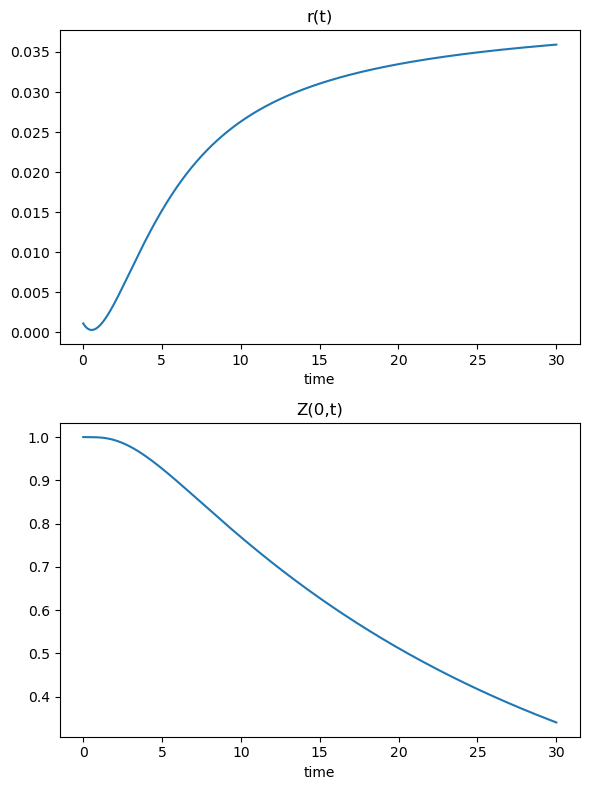

</div>

### 1.2 Survival Probabilities $Q(0,t)$

Let $f(t)=-lnQ(t)=\int_0^t{h(s)ds}$. We construct f(t) by a linear interpolation that connects the value of $f(t)$ at points $t=T_1,T_2,...,T_M$. 

It can be shown that $h(t)=h_k, t\in(T_{k-1},T_k], k=1,2,...,M$.

If we calibrate the value of $h_k$, we have
$$ Q(t)=exp(-\int_{0}^{t}{h(s)ds})=exp(-\sum_{i=1}^{k-1}{(T_i-T_{i-1})h_i+(t-T_{k-1})h_k}), t\in(T_{k-1},T_k]$$

The following code shows the calibration process of $h_k$.


```python
class Q(object):
    def __init__(self,):
        self.spreads = [103.07,104.68,106.74,110.31,113.38,116.98,128.78,143.51,159.43,164.13]
        self.spreads = [x/10000 for x in self.spreads]
        self.ttm = np.array(ttm)
        self.md = md
        self.R = 0.45
        self.h = np.zeros((len(self.spreads),))
        
    def Q(self):
        def _inner(t):
            for i in range(len(self.spreads)):
                if t<=self.ttm[i]:
                    break
            if i==0:
                return np.exp(-t*self.h[0])
            else:
                return np.exp(-(self.ttm[0]*self.h[0] + np.sum(self.h[1:i]*(self.ttm[1:i]-self.ttm[:i-1]))+(t-self.ttm[i-1])*self.h[i]))
        return np.vectorize(_inner)
    
    def dQ(self,i):
        Q_ = self.Q()
        if i==0:
            def _inner(t):
                return Q_(t) * (self.ttm[i-1]-t)
        else:
            def _inner(t):
                return np.where(t<self.ttm[i-1],0,Q_(t) * (self.ttm[i-1]-t))
        return _inner
    
    def K(self,i):
        return np.ceil(self.ttm[i]/m)
    
    def NR(self,i):
        Q_ = self.Q()
        dQ_ = self.dQ(i)
        K = self.K(i)
        
        self.h[i] = x0
        
        s = np.arange(0,K+1)/K * self.ttm[i]
        t = np.append(np.array([0]),get_payment_dates(self.md[i]))
                
        def V():
            term1 = np.sum((Z(s[:-1])+Z(s[1:]))*(Q_(s[:-1])-Q_(s[1:])))
            term2 = 0.5*np.sum((t[1:]-t[:-1])*Z(t[1:])*(Q_(t[:-1])+Q_(t[1:])))
            return (1-self.R)/2*term1-self.spreads[i]*term2
        
        def Vp():
            term1 = np.sum((Z(s[:-1])+Z(s[1:])) * (dQ_(s[:-1])-dQ_(s[1:])))
            term2 = 0.5 * np.sum((t[1:]-t[:-1]) * Z(t[1:]) * (dQ_(t[:-1])+dQ_(t[1:])))
            return (1-self.R)/2*term1-self.spreads[i]*term2
        
        while np.abs(V())>=eps:
            self.h[i] = self.h[i] - V()/Vp()
                    
    def main(self,):
        for i in range(len(self.spreads)):
            self.NR(i)
        return self.h
            
```

We roll those dates that fall on weekends to the next Monday. Related code is shown is the ipynb file. The class above call calculate the survival probibilities and calibrate the parameters using market data. 

The method Q() and dQ() will return a function which can calculate the survival probibilities and derivative of survival probibilities. The method NR() is the most important function which can calibrate certain $h_i$ using *Newton-Raphson* method. Since we only need $h_1,h_2,...,h_{k-1}$ to calibrate $h_k$, we can calibrate them sequentially, which is done by method main().

After we have calibrated all the $h_k$, we directly use the method Q() and its return is the survival probabilities function we want.

The calibration of $h_k$ is shown below.

<div align="center">
  
| Time to Maturity |      $h$      |
|:----------------:|:----------:|
|        6M($h_1$)        |  0.018740  |
|        1Y($h_2$)        |  0.019369  |
|        2Y($h_3$)        |  0.019791  |
|        3Y($h_4$)        |  0.021416  |
|        4Y($h_4$)        |  0.022386  |
|        5Y($h_5$)        |  0.024139  |
|        7Y($h_6$)        |  0.029763  |
|       10Y($h_7$)        |  0.034541  |
|       20Y($h_8$)        |  0.034676  |
|       30Y($h_9$)        |  0.035232  |

</div>

The survival probabilities curve is shown below.

<div align="center">

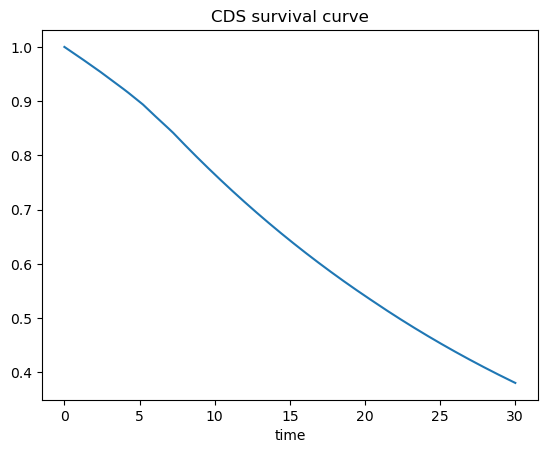

</div>

### 1.3 Mark-to-market Value of a CDS

After we get the survival probabilities function, it is easy to calculate the mark-to-market value of a certain CDS. Related code is shown below.

```python
protection = (1-R)/2 * np.sum((Z(s[:-1])+Z(s[1:]))*(Q(s[:-1])-Q(s[1:])))
RPV01 = (0-pre)*Z(t[0])*(1-Q(t[0])) + 0.5*(t[0]-0)*Z(t[0])*(1-Q(t[0])) + (t[0]-pre)*Z(t[0])*Q(t[0]) + np.sum(0.5*(t[1:]-t[:-1])*Z(t[1:])*(Q(t[:-1])+Q(t[1:])))
premium = S*RPV01
V = protection - premium
print("mark-to-market value of this CDS = ",V*fc)
print("clean mark-to-market value of this CDS = ",(V-(0-pre)*S)*fc)
print("accrued interest = ",(0-pre)*S*fc)
```

Note that the $t_{-1}$ should be 15 February 2014, but that date is Saturday. So we roll it to 17 February 2014.

# 2. Results

### Plots of the term structure of interest rates
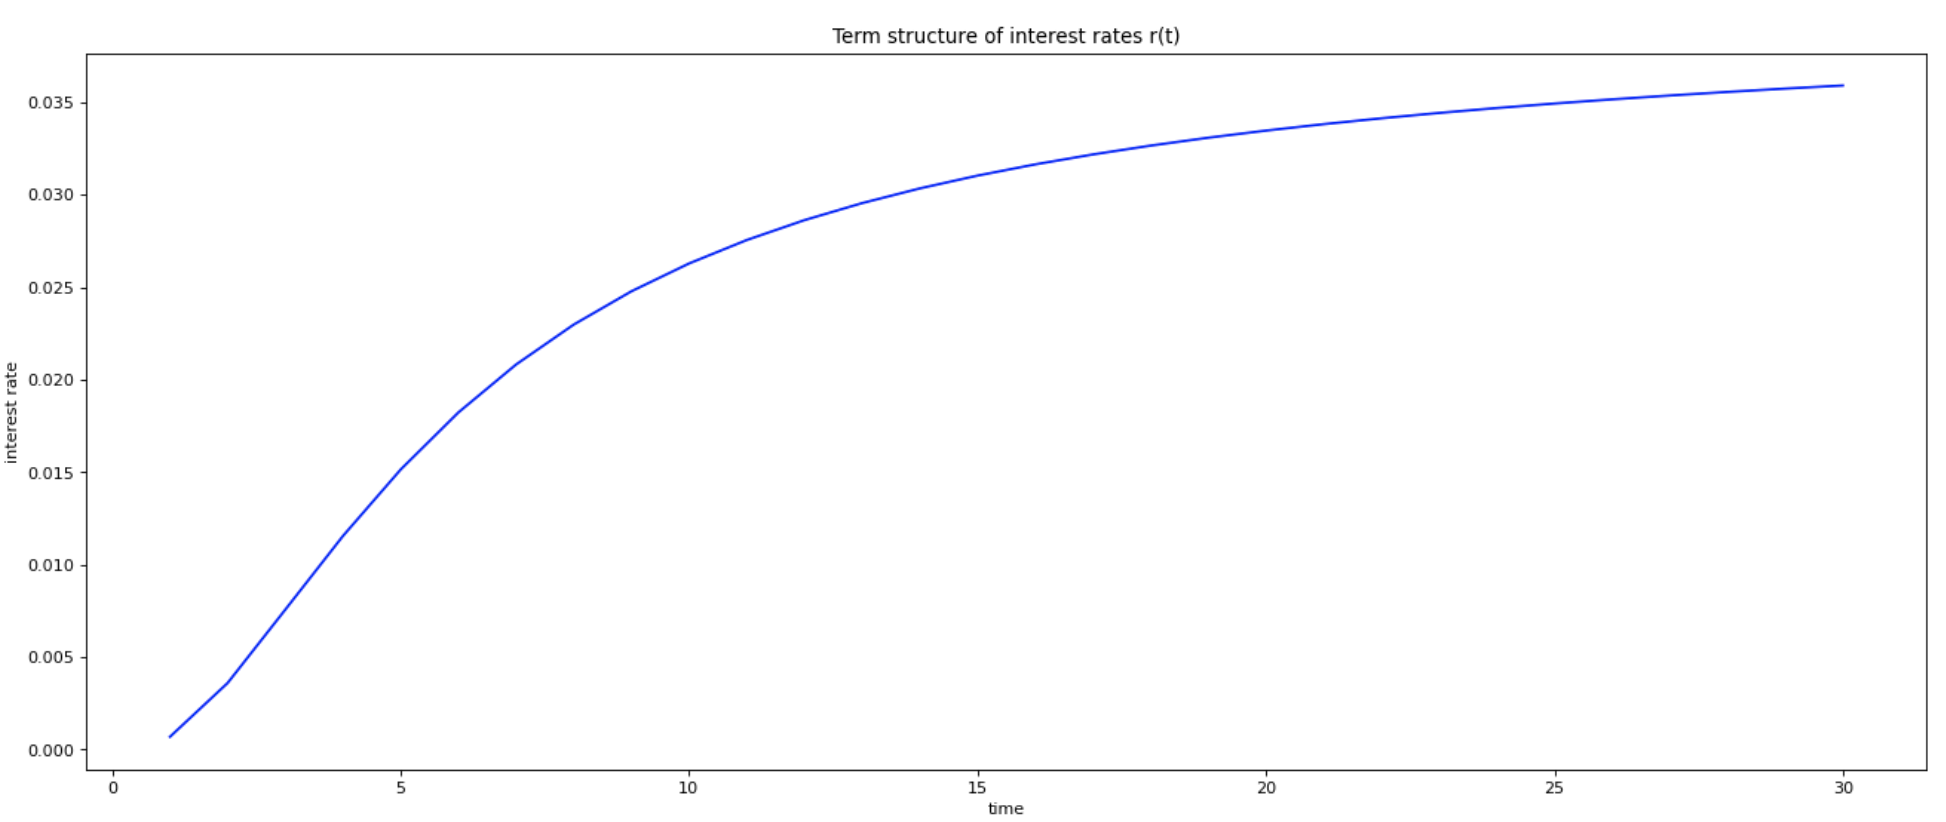
### Table for t = 1,2, .... , 30
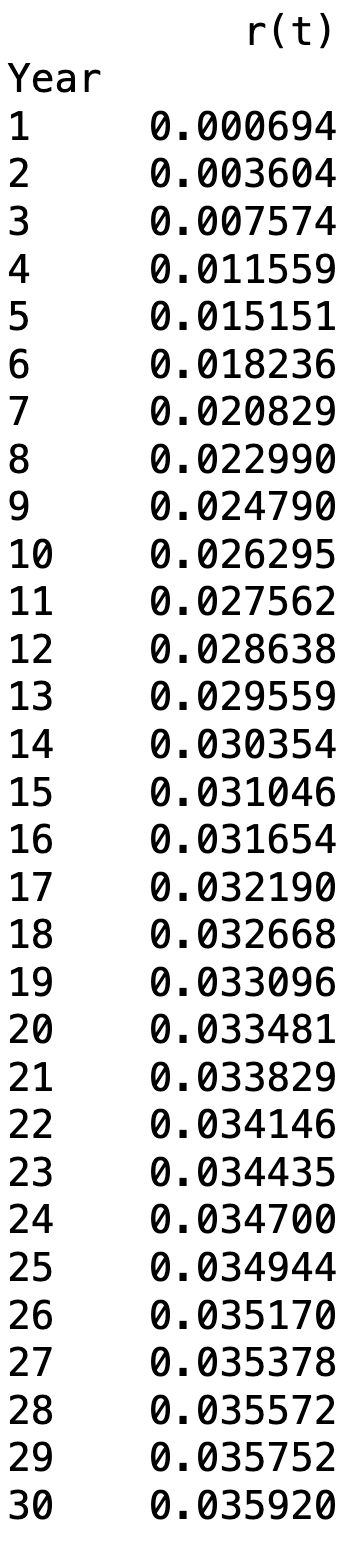

### Plots of the term structure of discount factors
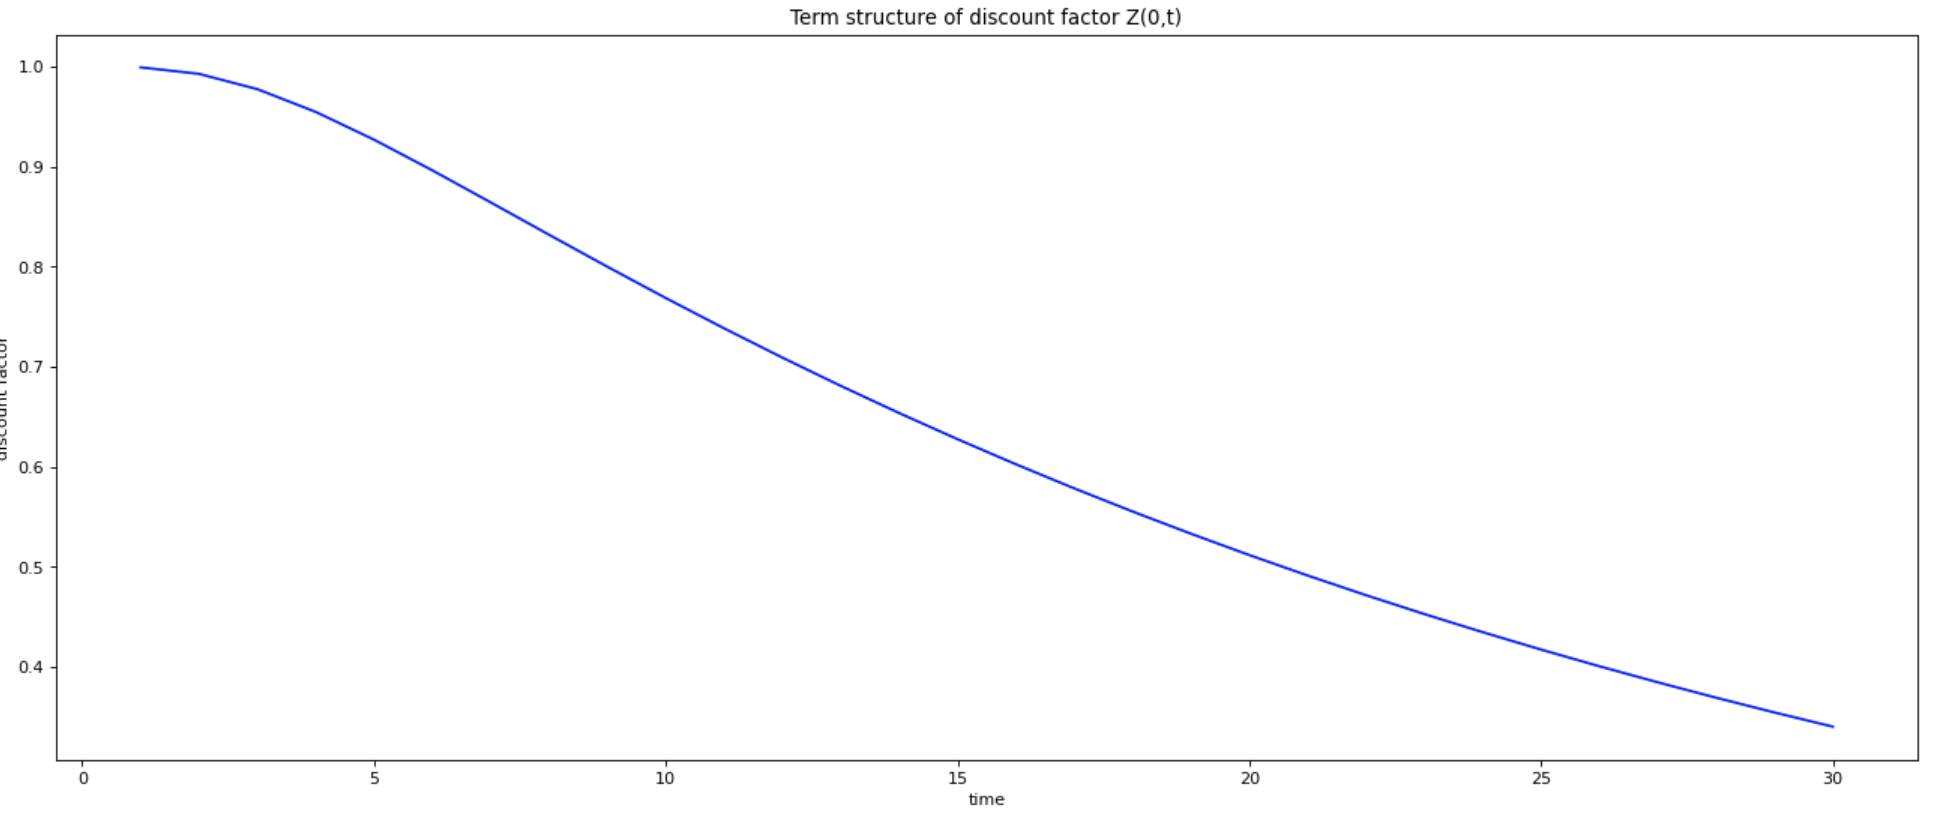
### Table for t = 1,2, .... , 30
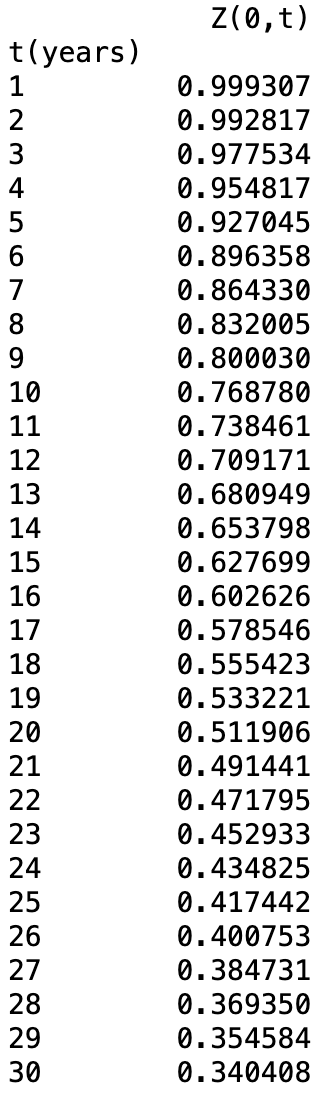

### Plots of the term structure of forward default rates
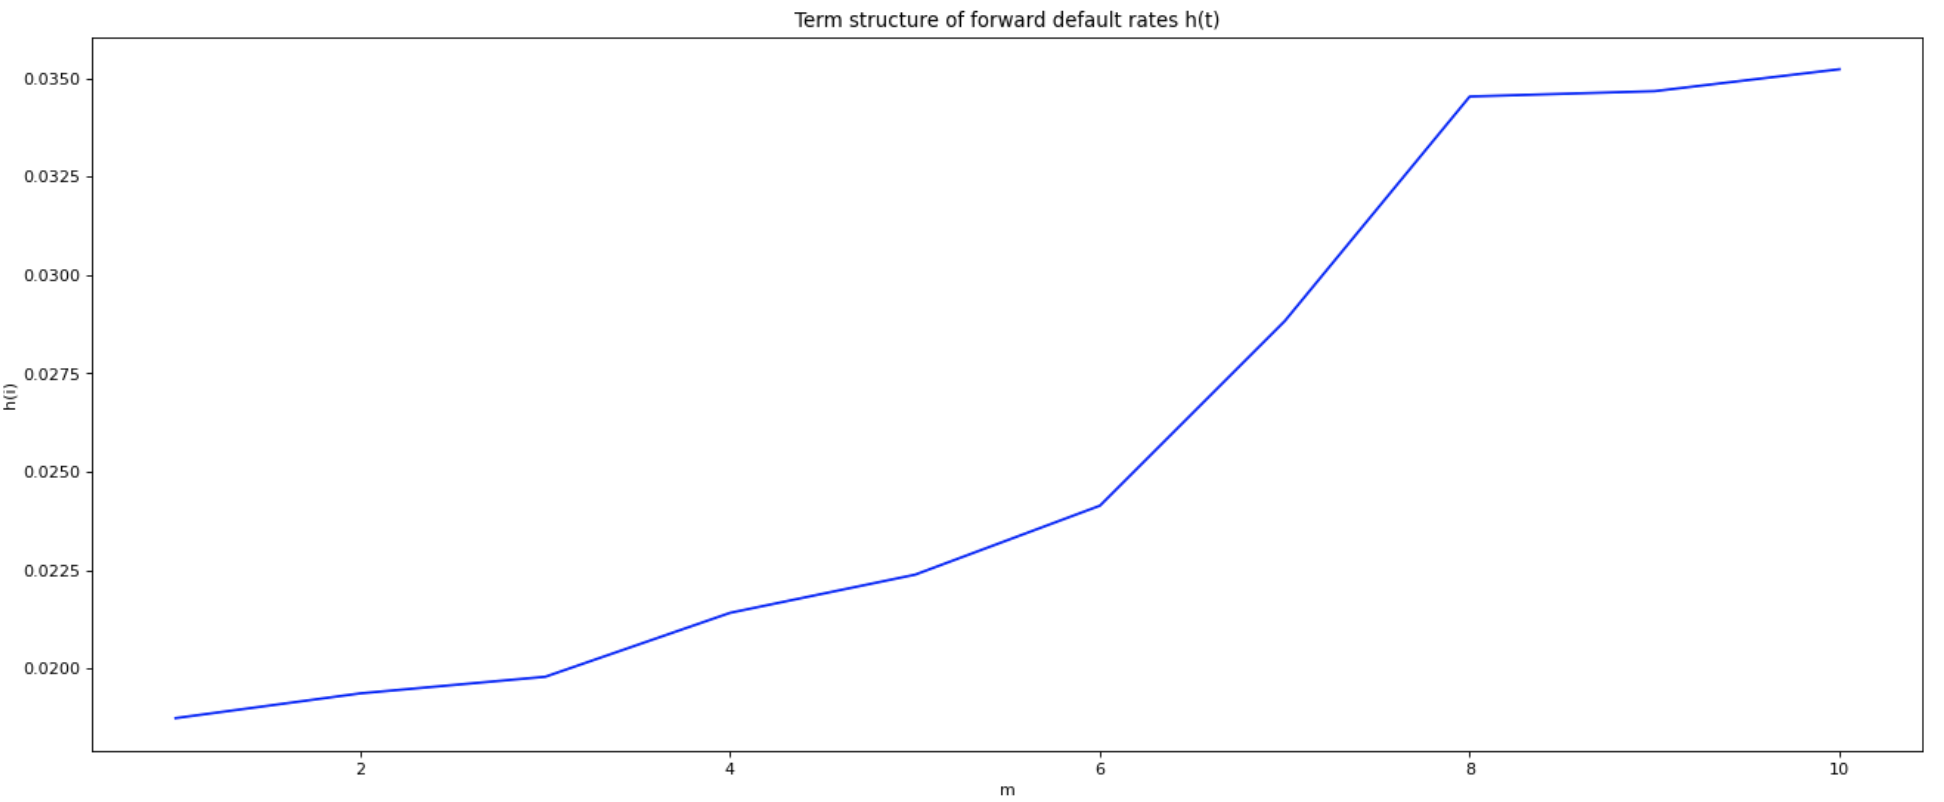
### Table for t = 1,2, .... , 10
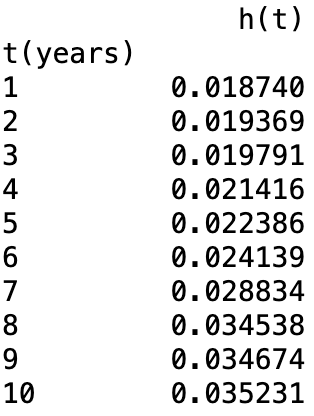

### Plots of survival probability curve
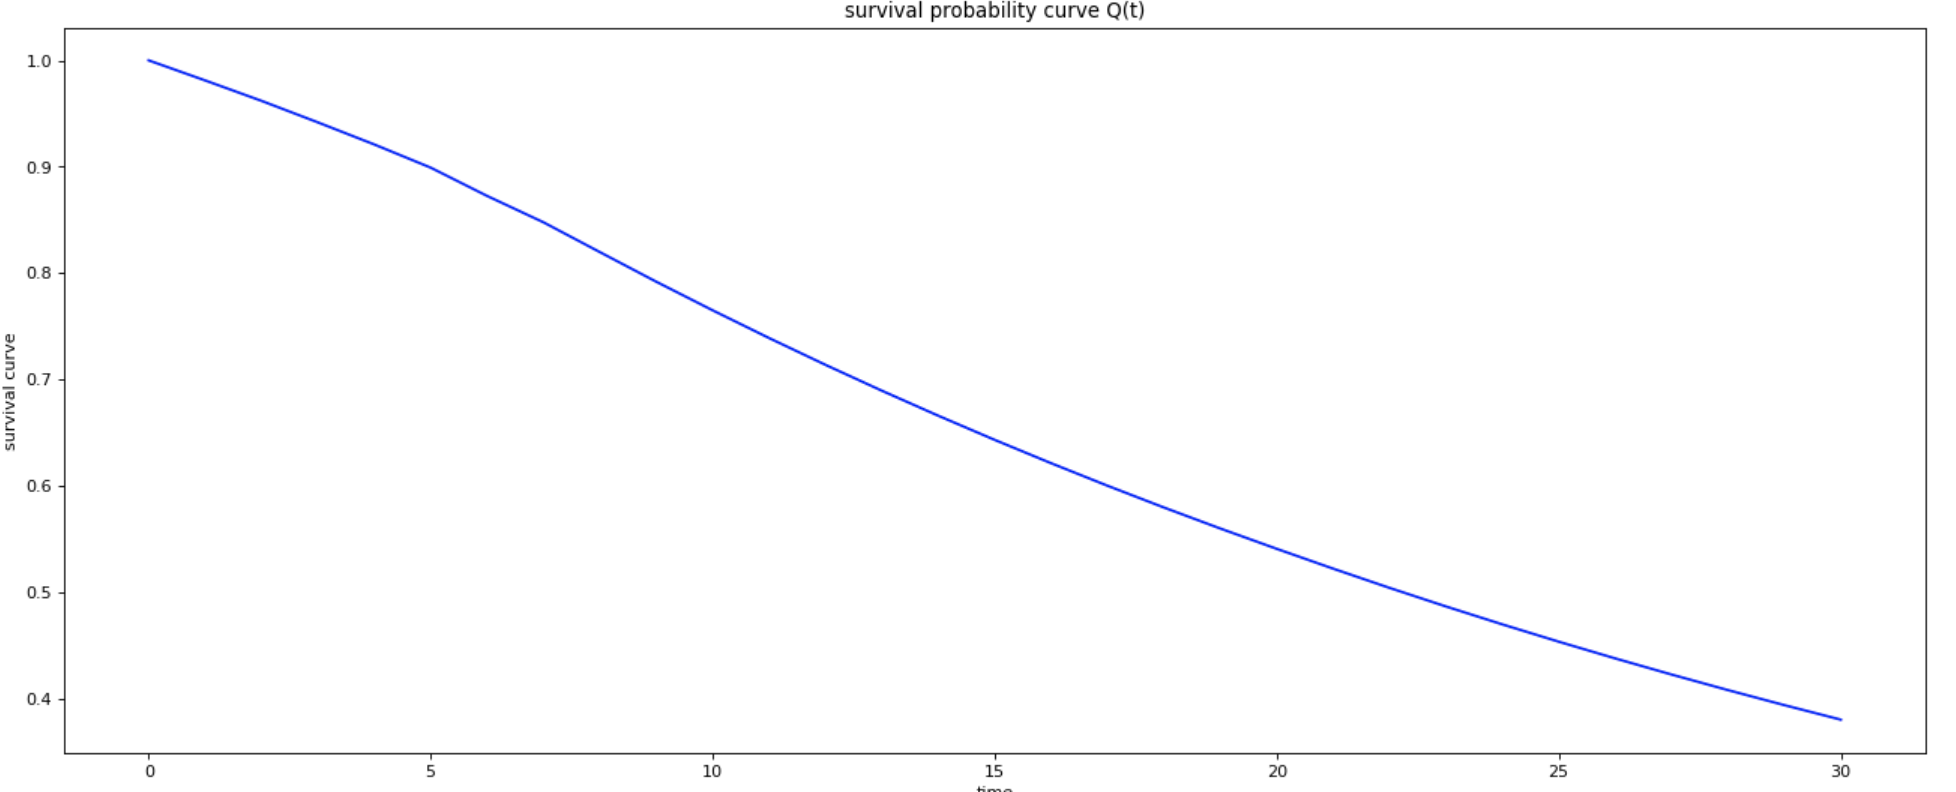
### Table for t = 0,1, .... , 30
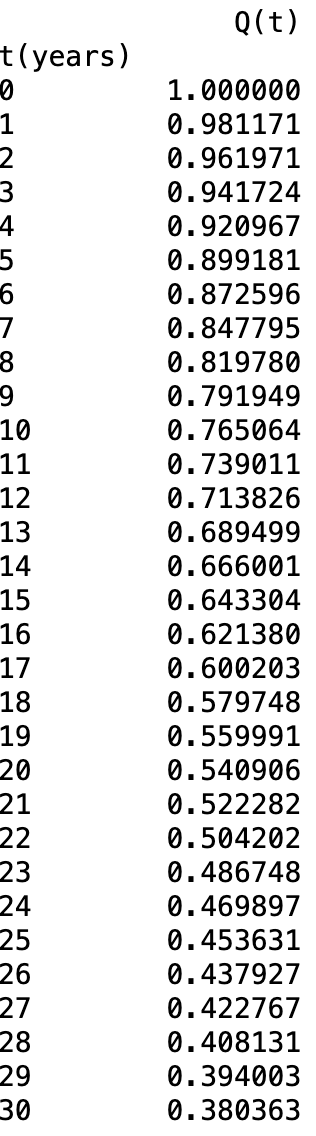

### CDS Valuation
Value of protection leg =  16195508.073195938\
Value of premium leg =  23892781.996247705\
Mark-to-market value of this CDS =  -7697273.923051767\
Clean mark-to-market value of this CDS =  -7749218.367496212\
Accrued interest =  51944.444444444445

# 3. Discussion

In this assignment, by implementing a reduced-form model, we price a Credit Default Swap (CDS). 

First, let's look at the term structure of interest rates. From the graph, we observe that the term structure is upward sloping, and long-term interest rates are higher than short-term interest rates. This could be explained by  the expectation of rising inflation or a compensation for the higher risk associated with longer periods. From the table we confirm the observation that the rates start very low in year 1 and gradually increase each year. Also, we can see both the graph and the table data are continuous and smooth, which indicates that the Nelson-Siegel model provides a good fit for the data, as it is capable of capturing the overall shape of the term structure without  kinks.

Then, let's look at the term structure of discount factors. The graph is a downward sloping curve starting at a value close to 1 and decreasing as time increases. This is consistent with our understanding of the time value of money, which suggests that the present value of a future cash flow decreases as time elapses. We can also identify a convex shape to the curve, with a steeper decline in the early years and a more gradual decline at later stages, which reflects the increasing impact of compounding as time elapses. Briefly, it give a clear view of present value of future cash flows are valued at present, based on Nelson-Siegel approach. 

As for the forward default rate, we can see the graph is an upward-sloping curve, indicating an increase in the forward default rate as time progresses. From the table we can see there is noticeable jumps in the rate between years 6 and 7 and between years 7 and 8. It can be explained by multiple ways, such as a specific market expectation of increased default risk or a macroeconomic event anticipated around that time. The increasing nature coincides with our initial belief, and we can see in ten years time, the rate almost doubles. Also, the gradual rate in first 5 yaer may suggest the market foresees a stable economic environment in the short term, while in longer time, the expectation is more volatile.

For the survival probability curve, we can see it is monotonically decreasing, which is expected as the probability of survival decreases over time. The curve starts at 1.0 when t=0, which means the survival probability is 100% at the current time, and when t=30. the survival probability is only about 38%. Also, we can see there are no sudden drops or increases, indicating a continuous, gradual increase in the cumulative default risk over time rather than any sudden spikes in default risk at specific time intervals. Also, this curve pattern is consistent with an increasing forward default rate, which would  result in lower survival probabilities over time.

And for our final result:

Protection Leg:
The protection leg is the present value of the expected payout in the event of a default. Our final value for protection leg is about $16,195,508.07, which represents the cost that the seller of the CDS would expect to bear if a credit event occurs. This is what the protection seller would pay out to the protection buyer.

Premium Leg:
The premium leg is the present value of the payments that the buyer of the protection pays to the seller. Our value for the premium leg is about $23,892,781.99. This is the income the seller of the CDS would expect to receive over the life of the contract in return for providing protection.

Mark-to-Market Value:
The mark-to-market value of the CDS is the difference between the protection leg and the premium leg. From previous result, our MTM value is about -$7,697,273.92. A negative value indicates that the value of the protection leg is less than the value of the premium leg. For the protection buyer, this means that the cost of the protection (the premiums paid) is higher than the current value of the protection being provided. If the protection buyer were to settle or terminate the contract at this mark-to-market value, they would incur a loss.

Accrued Interest:
The accrued interest is the amount of premium that has accumulated since the last premium payment date. Our result  is $51,944.44. It represents the amount of premium that the protection buyer owes the seller for the protection up until the current date.


Clean Mark-to-Market Value:
The clean mark-to-market value adjusts the mark-to-market value by subtracting any accrued interest. This is typically done to separate the valuation of the contract from the day-to-day accrual of premium payments. The given clean mark-to-market value is -$7,749,218.37, which is slightly more negative than the gross mark-to-market value.

In conclusion, from these values, we can see the the accrued interest is relatively insignificant comapred to the mark-to-market value, thus, it suggests that the change in the MTM value is mainly due to changes in market perceptions of risk or interest rates rather than the accumulation of premium payments. In additional, we can see the premiums being paid by the protection buyer are significantly larger than the protection provided. It might be explaind that, now in the market, the credit risk is perceived to be being lower than when the CDS was first purchased, or there is a general decrease in credit spreads.
